
✅ YAML file test type summary written to: C:\GitHub\Android-Mobile-Apps\yaml_test_type_summary.csv


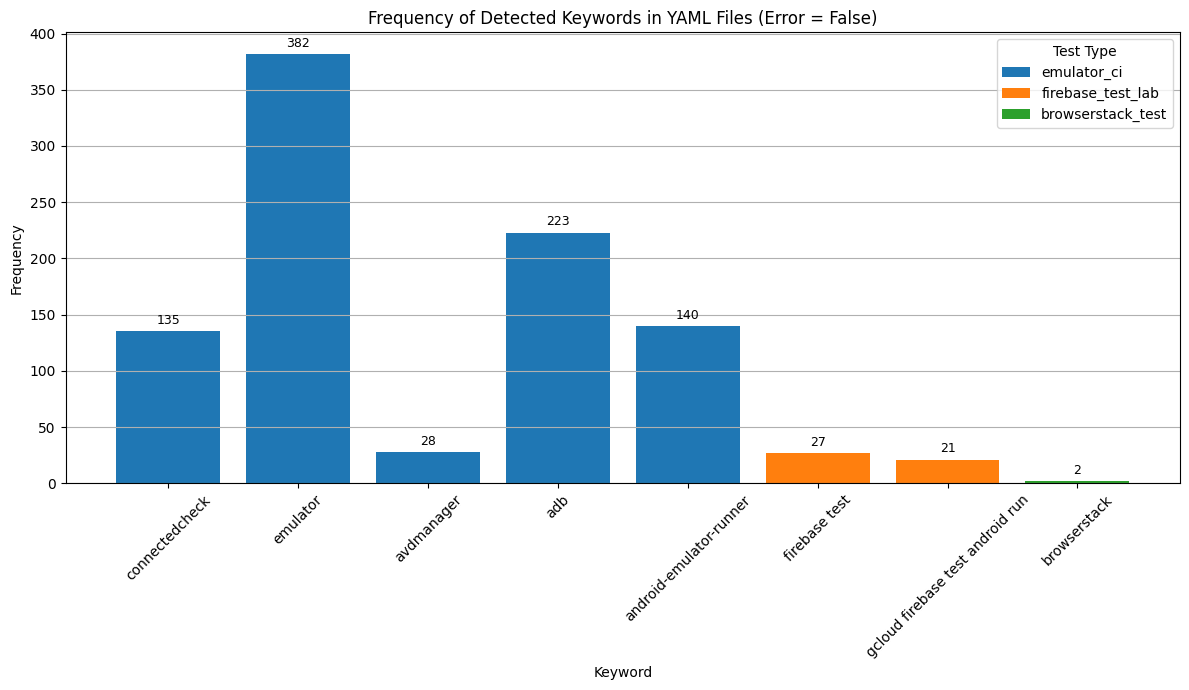

In [8]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# === CONFIG ===
PROJECTS_DIR = r"C:\Users\Admin\OneDrive\Education\Master of Info - Thesis\Config Files"
OUTPUT_DIR = r"C:\GitHub\Android-Mobile-Apps"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_CSV = os.path.join(OUTPUT_DIR, "yaml_test_type_summary.csv")

# === CLASSIFICATION KEYWORDS ===
TEST_TYPES = {
    'emulator_ci': ['connectedcheck', 'emulator', 'avdmanager', 'adb', 'android-emulator-runner'],
    'firebase_test_lab': ['firebase test', 'gcloud firebase test android run'],
    'appcenter_test': ['appcenter test run', 'microsoft/appcenter-test-cli-action'],
    'browserstack_test': ['browserstack', 'browserstack/github-actions']
}

# === DETECTION LOGIC ===
def detect_testing_types(yaml_text):
    text = yaml_text.lower()
    found = set()
    for label, keywords in TEST_TYPES.items():
        for kw in keywords:
            if kw in text:
                found.add(label)
    return found

# === YAML PARSER ===
def parse_yaml_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            raw = f.read().replace('\t', ' ')
            content = yaml.safe_load(raw)  # Just to validate syntax
            if not content:
                return {'types': set(), 'error': True, 'raw': raw}
            detected = detect_testing_types(raw)
            return {'types': detected, 'error': False, 'raw': raw}
    except Exception:
        return {'types': set(), 'error': True, 'raw': ''}

# === FILE SCANNER ===
yaml_results = []
raw_lookup = {}

for root, _, files in os.walk(PROJECTS_DIR):
    for file in files:
        if file.endswith(('.yml', '.yaml')):
            file_path = os.path.join(root, file)
            result = parse_yaml_file(file_path)

            yaml_results.append({
                'yaml_file': os.path.relpath(file_path, PROJECTS_DIR),
                'test_types': ', '.join(sorted(result['types'])) if result['types'] else 'none',
                'yaml_error': result['error']
            })

            # Save raw for keyword frequency if no error
            if not result['error']:
                raw_lookup[os.path.relpath(file_path, PROJECTS_DIR)] = result['raw']

# === EXPORT TO CSV ===
df = pd.DataFrame(yaml_results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✅ YAML file test type summary written to: {OUTPUT_CSV}")

# === FILTER VALID RECORDS FOR PLOTTING ===
df_filtered = df[(df['yaml_error'] == False) & (df['test_types'] != 'none')]

# === KEYWORD FREQUENCY COUNTS ===
keyword_counts = defaultdict(int)
for label, keywords in TEST_TYPES.items():
    for kw in keywords:
        for yaml_file in df_filtered['yaml_file']:
            if kw in raw_lookup.get(yaml_file, '').lower():
                keyword_counts[(label, kw)] += 1

# === CREATE PLOTTING DF ===
keyword_df = pd.DataFrame([
    {'Test Type': label, 'Keyword': kw, 'Count': count}
    for (label, kw), count in keyword_counts.items()
])

# === PLOT ===
plt.figure(figsize=(12, 7))
colors = plt.cm.tab10.colors
for i, label in enumerate(keyword_df['Test Type'].unique()):
    subset = keyword_df[keyword_df['Test Type'] == label]
    bars = plt.bar(subset['Keyword'], subset['Count'], label=label, color=colors[i % len(colors)])

    # Add count labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 3), textcoords='offset points',
                         ha='center', va='bottom', fontsize=9)

plt.title('Frequency of Detected Keywords in YAML Files (Error = False)')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Test Type')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


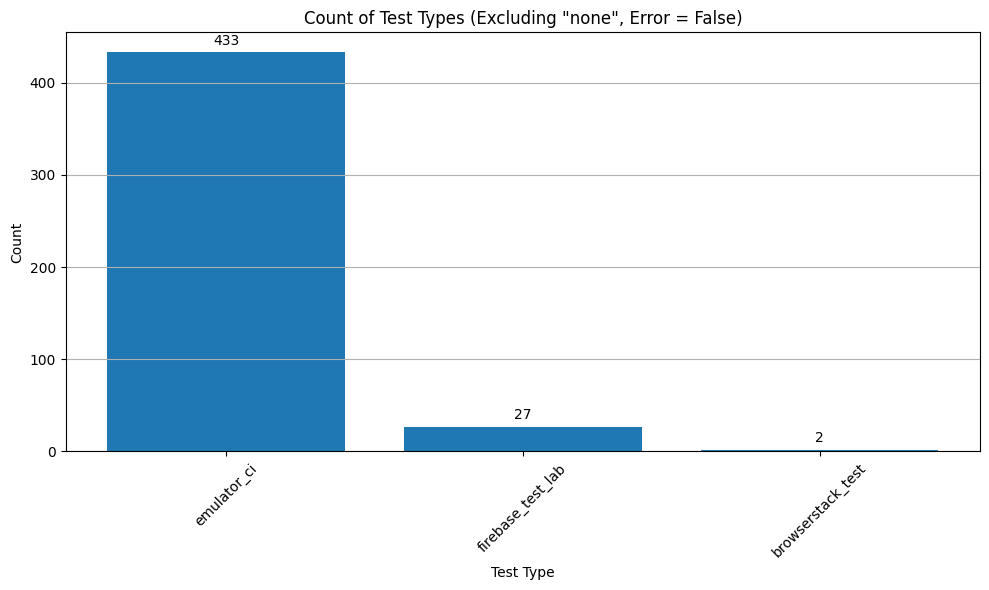

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Load the CSV file
csv_path = 'yaml_test_type_summary.csv'  # Update path if needed
df = pd.read_csv(csv_path)

# Filter records with yaml_error == False and test_types != 'none'
df_filtered = df[(df['yaml_error'] == False) & (df['test_types'] != 'none')]

# Split and explode test_types
test_types = df_filtered['test_types'].str.split(', ').explode()

# Count frequency of each test type
test_type_counts = Counter(test_types)

# Prepare DataFrame for plotting
plot_df = pd.DataFrame(test_type_counts.items(), columns=['Test Type', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(plot_df['Test Type'], plot_df['Count'])

# Add data labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Test Type')
plt.ylabel('Count')
plt.title('Count of Test Types (Excluding "none", Error = False)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()
